In [100]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [101]:
import matplotlib
import matplotlib.pyplot as plt
import glob
import math
import numpy as np
import pandas as pd

In [102]:
def curvature(h, ptmin, region_origin_radius,hardPtCut, first, rad=False) :
    region_origin_x = 0
    region_origin_y = 0
    x1 = h['r1']*np.cos(h['phi1']) if first else h['r2']*np.cos(h['phi2'])
    y1 = h['r1']*np.sin(h['phi1']) if first else h['r2']*np.sin(h['phi2'])
    x2 = h['r2']*np.cos(h['phi2']) if first else h['r3']*np.cos(h['phi3'])
    y2 = h['r2']*np.sin(h['phi2']) if first else h['r3']*np.sin(h['phi3'])
    x3 = h['r3']*np.cos(h['phi3']) if first else h['r4']*np.cos(h['phi4'])
    y3 = h['r3']*np.sin(h['phi3']) if first else h['r4']*np.sin(h['phi4'])
    
    distance_13_squared = (x1 - x3)*(x1 - x3) + (y1 - y3)*(y1 - y3)
    tan_12_13_half_mul_distance_13_squared = abs(y1 * (x2 - x3) + y2 * (x3 - x1) + y3 * (x1 - x2))
    # high pt : just straight
    straight = tan_12_13_half_mul_distance_13_squared * ptmin <= 1.0e-4*distance_13_squared
    def ifStraight() :
        distance_3_beamspot_squared = (x3-region_origin_x) * (x3-region_origin_x) + (y3-region_origin_y) * (y3-region_origin_y)
        dot_bs3_13 = ((x1 - x3)*( region_origin_x - x3) + (y1 - y3) * (region_origin_y-y3))
        proj_bs3_on_13_squared = dot_bs3_13*dot_bs3_13/distance_13_squared
        distance_13_beamspot_squared  = distance_3_beamspot_squared -  proj_bs3_on_13_squared
        return distance_13_beamspot_squared < (region_origin_radius+phiCut)*(region_origin_radius+phiCut)
    
    def standard() :
        # 87 cm/GeV = 1/(3.8T * 0.3)
        # 165 cm/GeV = 1/(2T * 0.3)
    
        # take less than radius given by the hardPtCut and reject everything below
        minRadius = hardPtCut*87 #  // FIXME move out and use real MagField
    
        det = (x1 - x2) * (y2 - y3) - (x2 - x3) * (y1 - y2)
    
        offset = x2 * x2 + y2*y2
    
        bc = (x1 * x1 + y1 * y1 - offset)*0.5
    
        cd = (offset - x3 * x3 - y3 * y3)*0.5
    
    
    
        idet = 1./ det;
    
        x_center = (bc * (y2 - y3) - cd * (y1 - y2)) * idet
        y_center = (cd * (x1 - x2) - bc * (x2 - x3)) * idet
    
        radius = np.sqrt((x2 - x_center)*(x2 - x_center) + (y2 - y_center)*(y2 - y_center))
        if rad: return radius
        def domore() :
            centers_distance_squared = (x_center - region_origin_x)*(x_center - region_origin_x) + (y_center - region_origin_y)*(y_center - region_origin_y)
            #minimumOfIntersectionRange = (radius - region_origin_radius_plus_tolerance)*(radius - region_origin_radius_plus_tolerance)
            #ok = centers_distance_squared >= minimumOfIntersectionRange
            return np.sqrt(centers_distance_squared)-radius - region_origin_radius


        # return domore().where(radius > minRadius, radius <= minRadius)
        return domore()
    
    #return ifStraight().where(straight,standard())
    return standard()

In [103]:
def deltaphi(a,b,ch) :
    d = b-a
    cd = ch*d
    ca = ch*a
    return cd*(1.+0.5*ca*(ca+cd)+cd*cd*0.1667)

In [104]:
def alignRZ(h, ptmin, first) :
    ri = h['r1'] if first else h['r2']
    zi = h['z1'] if first else h['z2']
    rm = h['r2'] if first else h['r3']
    zm = h['z2'] if first else h['z3']
    ro = h['r3'] if first else h['r4']
    zo = h['z3'] if first else h['z4']
    radius_diff = abs(rm - ro)
    distance_13_squared = radius_diff*radius_diff + (zm - zo)*(zm - zo)
    
    pMin = ptmin*np.sqrt(distance_13_squared) #this needs to be divided by radius_diff later
    
    tan_12_13_half_mul_distance_13_squared = abs(zm * (ri - ro) + zi * (ro - rm) + zo * (rm - ri)) 
    return tan_12_13_half_mul_distance_13_squared * pMin/(distance_13_squared * radius_diff)

In [105]:
def doublets(hits,l1,l2,cut=0.2) :
    nd=0
    for h1 in l1.itertuples() :
        phi = h1.phi
        hh = l2['phi'].searchsorted([phi-cut,phi+cut])
        hits.loc[h1.Index,'up0'] = hh[0]
        hits.loc[h1.Index,'up1'] = hh[1]
        nd += hh[1]-hh[0]
    return nd

In [106]:
def ml(pt1,pz1,pt2,pz2) :
    dp = pt1*pt2+pz1*pz2
    m1 = pt1*pt1+pz1*pz1
    m2 = pt2*pt2+pz2*pz2
    corr =  pt1/np.sqrt(m1)
    dp /=np.sqrt(m1*m2)
    dt = np.arccos(dp[dp<1]) 
    dtn = dt*np.sqrt(m1)*corr
    return dt,dtn

In [107]:
file = '/Users/innocent/data/pixHits.csv'
hits = pd.read_csv(file, delimiter=" ")
print '#hits', len(hits)
hits['seq'] = hits['layer'] + 4*(1-hits['isBarrel'])
hits.sort_values(by=['trackID','r'],inplace=True)
print hits


#hits 427014
          trackID         pt         r          z       phi  isBarrel  layer  \
0          100005   0.890291   5.12720 -49.324700 -2.098970         0      3   
1          100005   0.891751   5.21688 -50.166400 -2.098250         0      3   
2          100008   2.257280   2.74074  -9.934940  0.763363         1      1   
3          100009   0.843968   6.83328 -49.378900  1.950680         0      3   
4          100010   0.237142   6.59834 -26.476900 -2.260320         1      2   
5          100010   0.233561   8.24110 -33.225500 -2.302020         0      1   
6          100010   0.232427   8.28708 -33.423900 -2.303130         0      1   
7          100010   0.232949  10.18960 -41.332000 -2.350670         0      2   
8          100010   0.232166  11.72190 -47.760200 -2.389210         0      3   
9          100010   0.230056  11.76510 -47.946100 -2.390430         0      3   
10         100011   0.616130   3.29406  -8.165820  1.220400         1      1   
11         100011   0.61598

87191 75485 60819 48981 54155 51781 48602


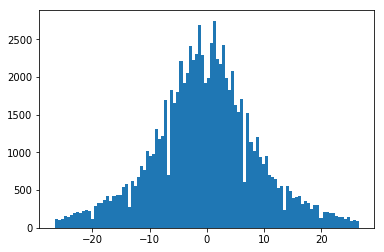

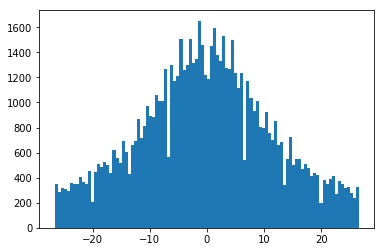

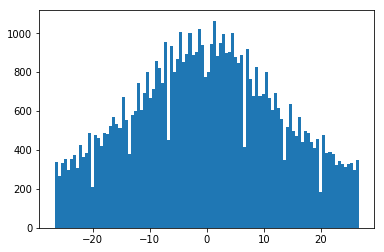

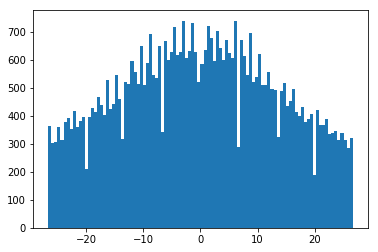

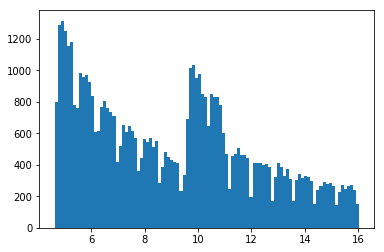

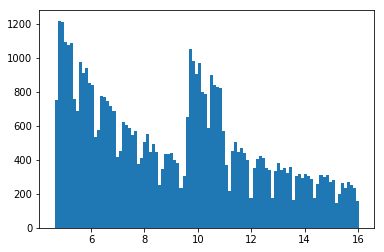

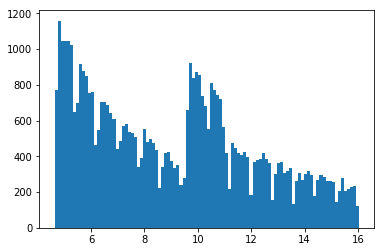

In [108]:
hb1 = hits.query('seq==1')
hb2 = hits.query('seq==2')
hb3 = hits.query('seq==3')
hb4 = hits.query('seq==4')
hf1 = hits.query('seq==5')
hf2 = hits.query('seq==6')
hf3 = hits.query('seq==7')

print len(hb1), len(hb2), len(hb3), len(hb4), len(hf1), len(hf2), len(hf3)
plt.hist(hb1['z'],log=False, bins=100)
plt.show()
plt.hist(hb2['z'],log=False, bins=100)
plt.show()
plt.hist(hb3['z'],log=False, bins=100)
plt.show()
plt.hist(hb4['z'],log=False, bins=100)
plt.show()
plt.hist(hf1['r'],log=False, bins=100)
plt.show()
plt.hist(hf2['r'],log=False, bins=100)
plt.show()
plt.hist(hf3['r'],log=False, bins=100)
plt.show()


In [109]:
print 'min/max'
print hb1.agg(['min','max'])
print hb2.agg(['min','max'])
print hb3.agg(['min','max'])
print hb4.agg(['min','max'])
print hf1.agg(['min','max'])
print hf2.agg(['min','max'])
print hf3.agg(['min','max'])

min/max
       trackID          pt        r        z      phi  isBarrel  layer  seq
min     100008    0.200008  2.73876 -26.5584 -3.14008         1      1    1
max  100000482  208.643000  3.37197  26.5703  3.14139         1      1    1
       trackID          pt        r        z      phi  isBarrel  layer  seq
min     100010    0.200002  6.57758 -26.6486 -3.14124         1      2    2
max  100000482  196.038000  7.24934  26.6184  3.14146         1      2    2
       trackID          pt        r        z      phi  isBarrel  layer  seq
min     100011    0.200015  10.7075 -26.6525 -3.14152         1      3    3
max  100000482  196.039000  11.3352  26.6503  3.14136         1      3    3
       trackID          pt        r        z      phi  isBarrel  layer  seq
min     100014    0.200014  15.8152 -26.6426 -3.14148         1      4    4
max  100000478  208.637000  16.4356  26.6525  3.14139         1      4    4
       trackID         pt        r        z      phi  isBarrel  layer  seq
min  

In [110]:
def build(hh,n) :
 return pd.DataFrame({ 'z'+n : hh['z'],
                    'r'+n : hh['r'],
                    'phi'+n : hh['phi'],
                    'pt'+n : hh['pt'],
                    'trackID' : hh['trackID']
                       })


In [111]:
t12 = pd.merge(build(hb1,'1'),build(hb2,'2'),on='trackID')
t123 = pd.merge(t12,build(hb3,'3'),on='trackID')
t1234 = pd.merge(t123,build(hb4,'4'),on='trackID')
print len(t1234)
t1231 = pd.merge(t123,build(hf1,'4'),on='trackID')
print len(t1231)
t121 = pd.merge(t12,build(hf1,'3'),on='trackID')
t1212 = pd.merge(t121,build(hf2,'4'),on='trackID')
print len(t1212)
t11 = pd.merge(build(hb1,'1'),build(hf1,'2'),on='trackID')
t112 = pd.merge(t11,build(hf2,'3'),on='trackID')
t1123 = pd.merge(t112,build(hf3,'4'),on='trackID')
print len(t1123)

qall = pd.concat([t1234,t1231,t1212,t1123])
print len(qall)

34823
4072
13378
37771
90044


In [116]:
def plot(quad,mpt) :
  quadc = quad[quad['pt1']>mpt]

  print 'delta123'
  
#dt,dtn = ml(t123['tpt'],t123['tpz'],t123['tpt2'],t123['tpz2'])
#plt.hist(dt[dt<0.1], log=True, bins=100)
#plt.show()
#plt.hist(dtn[dtn<0.1], log=True, bins=100)
#plt.show()
    
  thcut = alignRZ(quadc,0.6,True)
  curv = curvature(quadc,0.6,0.2,0.2,True)
  rad = curvature(quadc,0.6,0.2,0.2,True,True)
  field = rad/quadc['pt1']
  print 'field'
  plt.hist(field[abs(field)<500],log=True, bins=100)
  plt.show()
  print 'thcut',len(thcut)
  plt.hist(thcut[thcut<0.1],log=True, bins=100)
  plt.show()
  plt.hist(curv[abs(curv)<0.4],log=True, bins=100)
  plt.show()

  print 'delta234'

  thcut = alignRZ(quadc,0.6,False)
  curv = curvature(quadc,0.6,0.2,0.2,False)
  rad = curvature(quadc,0.6,0.2,0.2,False,True)
  field = rad/quadc['pt1']
  print 'field'
  plt.hist(field[abs(field)<500],log=True, bins=100)
  plt.show()
  print 'thcut',len(thcut)
  plt.hist(thcut[thcut<0.1],log=True, bins=100)
  plt.show()
  plt.hist(curv[abs(curv)<0.4],log=True, bins=100)
  plt.show()


    
  print 'dphi'
  d1 = quadc['phi1']-quadc['phi2']
  plt.hist(d1[abs(d1)<0.3], bins=100,log=True)
  plt.show()
  d2 = quadc['phi2']-quadc['phi3']
  plt.hist(d2[abs(d2)<0.3], bins=100,log=True)
  plt.show()
  d3 = quadc['phi4']-quadc['phi3']
  plt.hist(d3[abs(d3)<0.3], bins=100,log=True)
  plt.show()

  print 'dz'
  d1 = quadc['z1']-quadc['z2']
  plt.hist(d1[abs(d1)<30], bins=100,log=True)
  plt.show()
  d2 = quadc['z2']-quadc['z3']
  plt.hist(d2[abs(d2)<30], bins=100,log=True)
  plt.show()
  d3 = quadc['z4']-quadc['z3']
  plt.hist(d3[abs(d3)<30], bins=100,log=True)
  plt.show()

  print 'dr'
  d1 = quadc['r1']-quadc['r2']
  plt.hist(d1[abs(d1)<20], bins=100,log=True)
  plt.show()
  d2 = quadc['r2']-quadc['r3']
  plt.hist(d2[abs(d2)<20], bins=100,log=True)
  plt.show()
  d3 = quadc['r4']-quadc['r3']
  plt.hist(d3[abs(d3)<20], bins=100,log=True)
  plt.show()



delta123
field


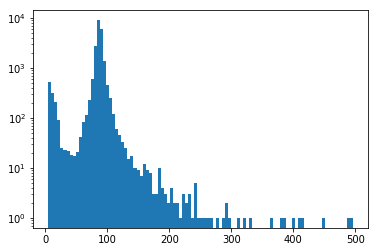

thcut 22577


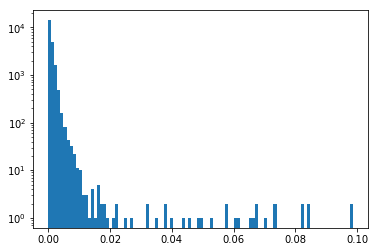

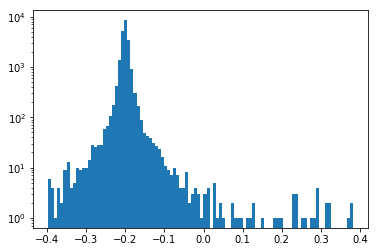

delta234
field


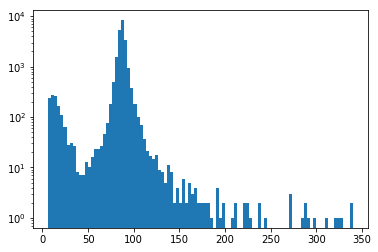

thcut 22577


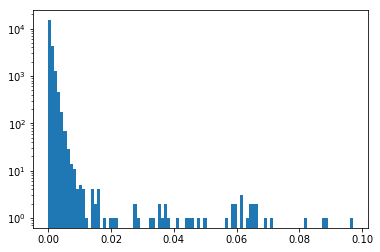

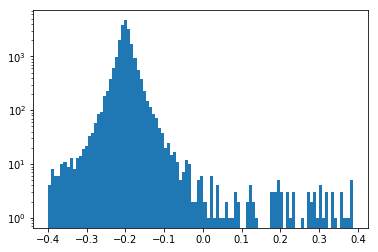

dphi


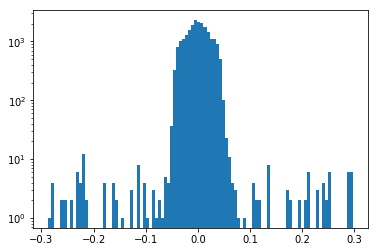

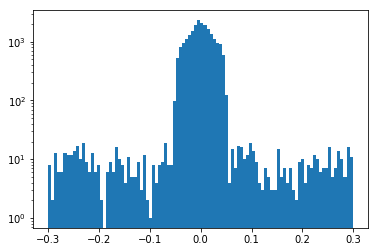

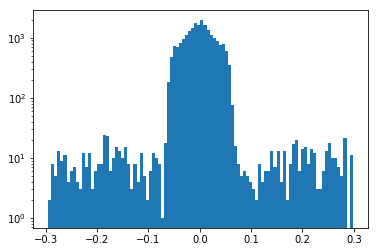

dz


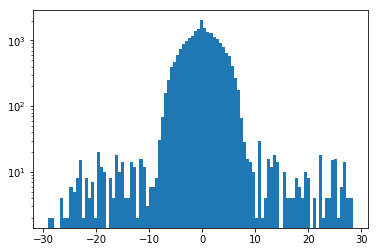

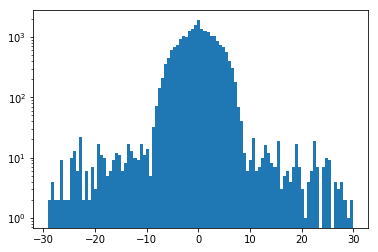

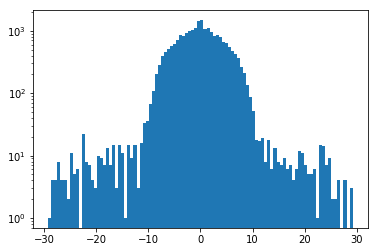

dr


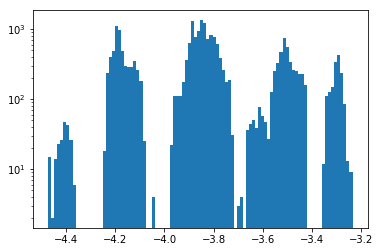

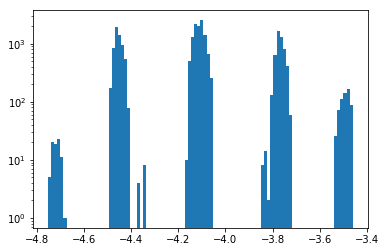

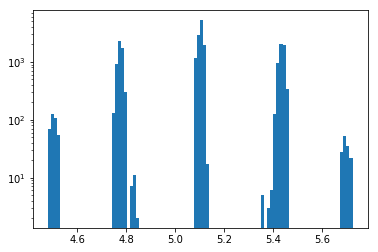

delta123
field


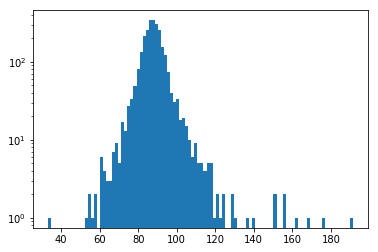

thcut 2685


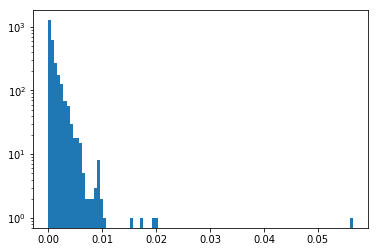

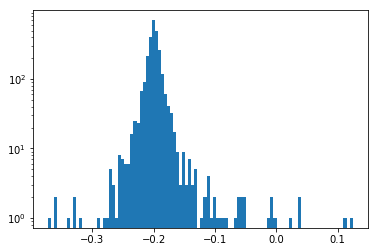

delta234
field


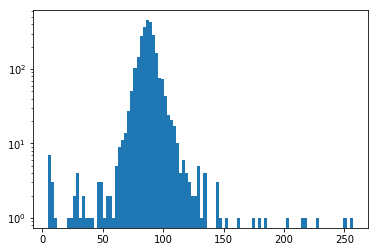

thcut 2685


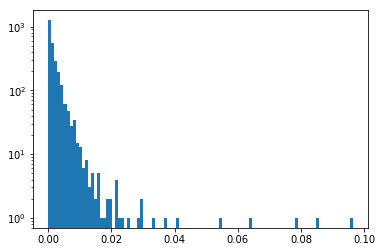

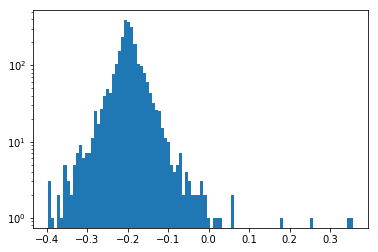

dphi


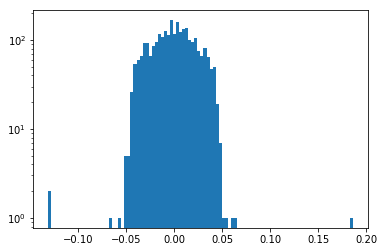

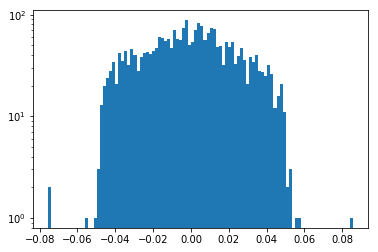

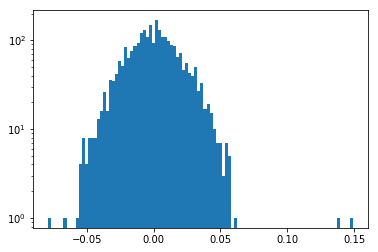

dz


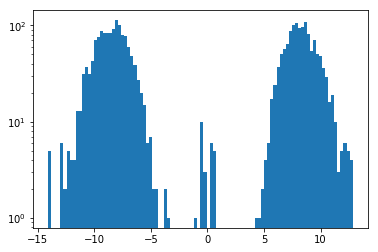

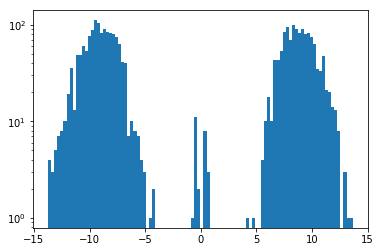

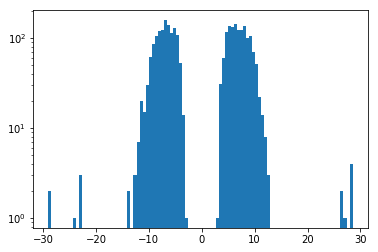

dr


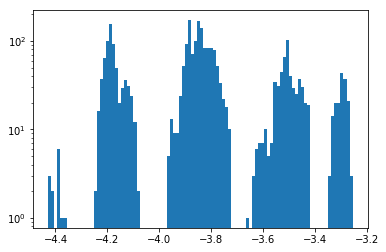

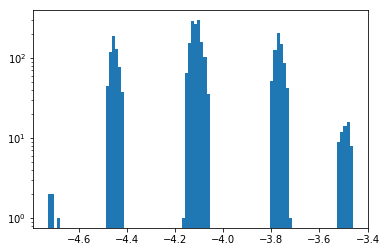

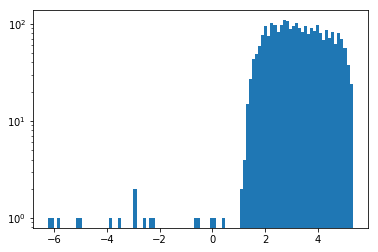

delta123
field


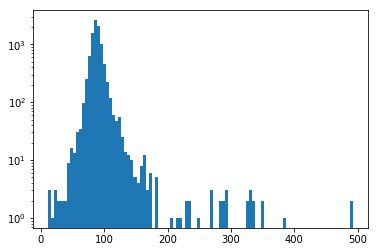

thcut 9436


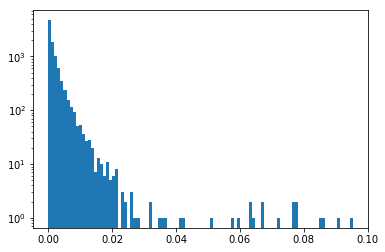

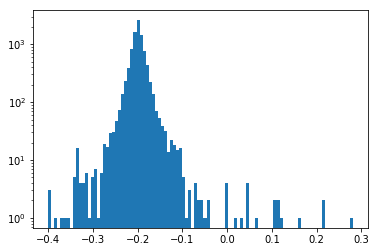

delta234
field


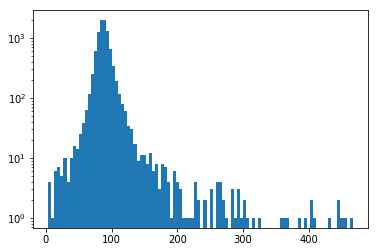

thcut 9436


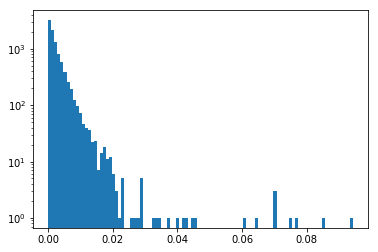

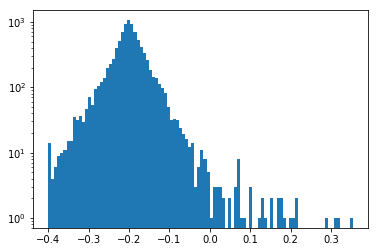

dphi


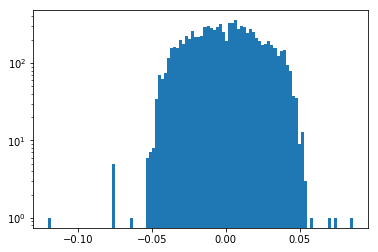

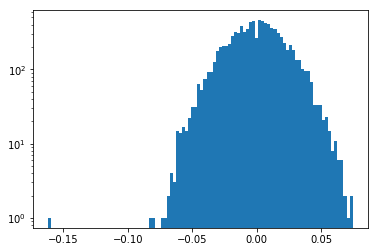

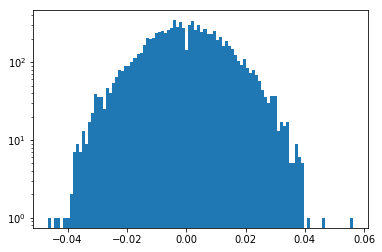

dz


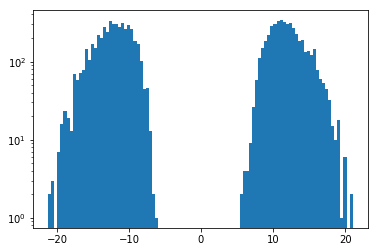

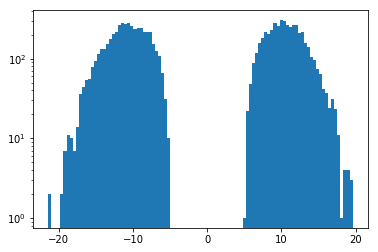

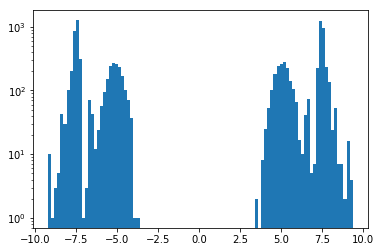

dr


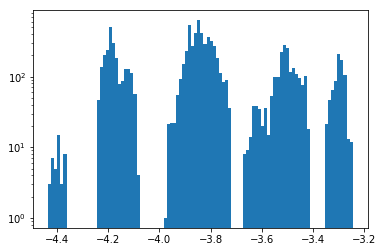

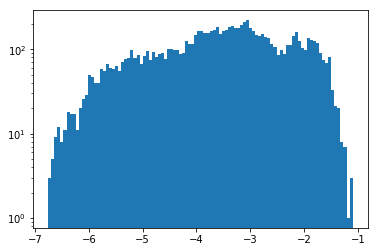

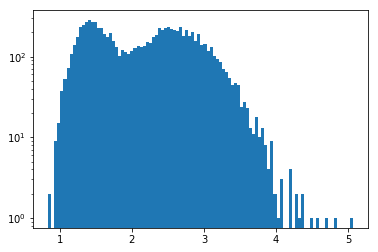

delta123
field


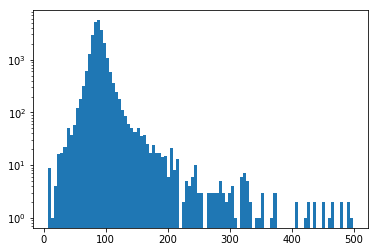

thcut 25318


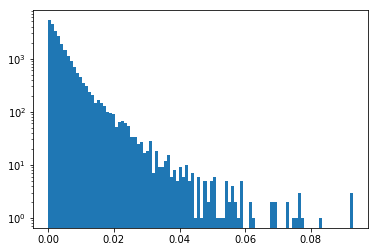

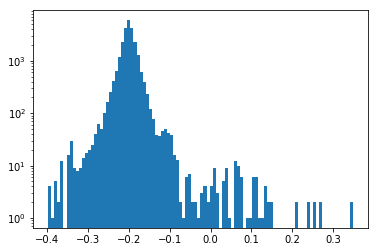

delta234
field


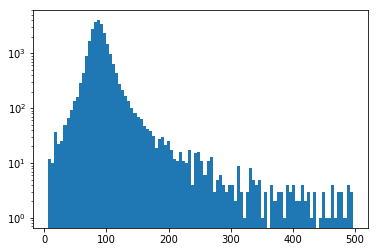

thcut 25318


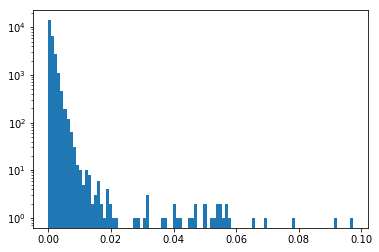

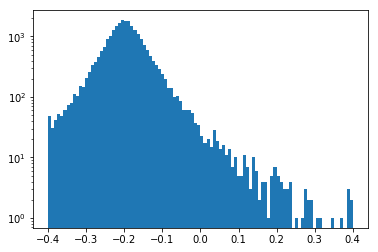

dphi


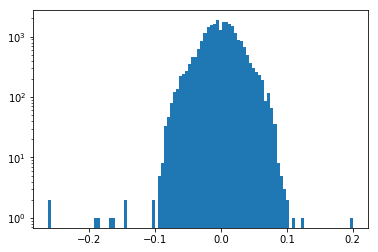

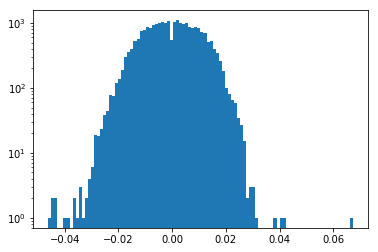

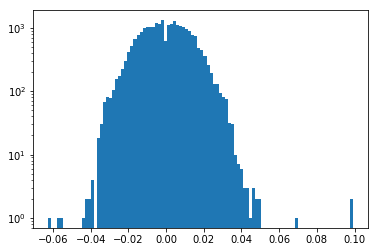

dz


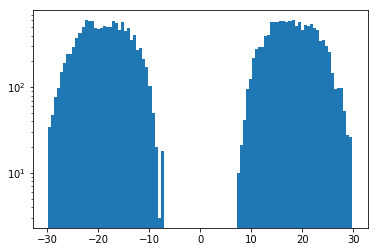

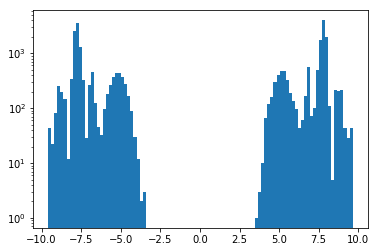

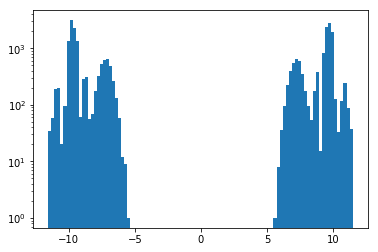

dr


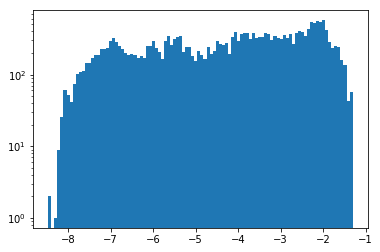

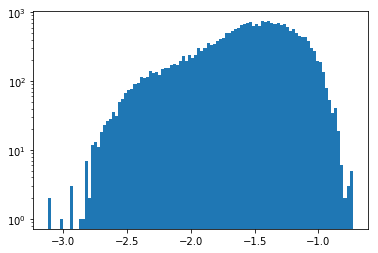

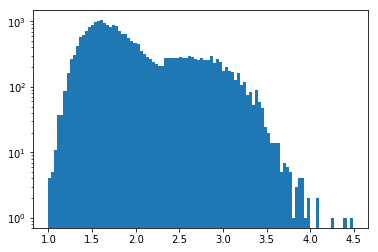

In [117]:
for quad in [t1234,t1231,t1212,t1123] :
  plot(quad,0.5)